In [25]:
import os
import numpy as np
from PIL import Image
import multiprocessing
import pycwt
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage import io, color
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
def read_image_files_from_directory(directory):
    image_files = []
    supported_formats = (".jpg", ".jpeg", ".png", ".gif", ".bmp")  # Add or remove formats as needed

    for file in os.listdir(directory):
        if file.lower().endswith(supported_formats):
            image_path = os.path.join(directory, file)
            image_files.append(image_path)

    return image_files


def plot_img(image_array):
    num_images = len(image_array)
    rows = 2
    cols = 2

    # Create a figure and axes
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 6))

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Generate subplots dynamically
    for i in range(num_images):
        # Plot image on each subplot
        axes[i].imshow(image_array[i], cmap='gray')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')

    # Hide any extra subplots if necessary
    for j in range(num_images, rows*cols):
        axes[j].axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
# directory_path = "data/archive/images"
# image_files = read_image_files_from_directory(directory_path)
# directory_path = "data/archive/masks"
# mask_files = read_image_files_from_directory(directory_path)

In [ ]:
# key = [k.split('/')[-1].replace('.jpg','') for k in image_files]


In [ ]:
# for k in key:
    
def segmentation(filename):
    image_path = [i for i in image_files if filename in i]
    mask_path = [i for i in mask_files if filename in i]
    image = Image.open(image_path[0])
    mask = Image.open(mask_path[0]).convert("L")
    # Convert the image to a NumPy array
    image_array = np.array(image)
    mask_array = np.array(mask)
    #     print(image_array.shape)
    #     print(mask_array.shape)
    mask_array = np.expand_dims(mask_array, axis=2)
    result_array = np.bitwise_and(image_array, mask_array)
    #     print(result_array)
    #     result_array = image_array * mask_array[:, :, np.newaxis]

    # Convert the result array back to an image
    result_image = Image.fromarray(result_array.astype(np.uint8))
    result_image.save('data/segmented/'+filename+'.jpg')
    # Display the result image
#     result_image.show()
#     break


# num_processes = multiprocessing.cpu_count()

# Create a pool of worker processes
# pool = multiprocessing.Pool(processes=num_processes)

# Process the images in parallel
# results = pool.map(segmentation, key)

# Close the pool of worker processes
# pool.close()
# pool.join()

In [32]:
# Example usage
image_path = 'data/segmented'  # Path to the image file
segmented_images = read_image_files_from_directory(image_path)
# print(segmented_images[:50])
# Open the image
image = Image.open(segmented_images[10])

# Convert the image to a NumPy array
image_array = np.array(image)

# Display the shape of the array
print("Image array shape:", image_array.shape)

def fdct(image):
    # Convert image to grayscale if necessary
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)

    # Perform the FDCT
    curvelets = ct.fdct2(image)

    return curvelets


def extract_lbp(image, radius=2, n_points=8, method='uniform'):
    # Convert image to grayscale
    gray_image = color.rgb2gray(image)

    # Compute LBP
    lbp = local_binary_pattern(gray_image, n_points, radius, method)

    return lbp


def extract_lbp_features(image):
    image = color.rgb2gray(image)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-7)
    return hist



def extract_glcm(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True):
    # Convert image to grayscale
    gray_image = color.rgb2gray(image)

    # Convert grayscale image to integer values
    gray_image = (gray_image * (levels - 1)).astype(np.uint8)

    # Compute GLCM
    glcm = graycomatrix(gray_image, distances, angles, levels=levels,
                        symmetric=symmetric, normed=normed)

    return glcm

# Example usage
# Load image
lbp_features = {'lbp':[],'images':[]}
# lbp = []
glcm_img = {'img':[],'contrast':[],'correlation':[],'energy':[],'dissimilarity':[],'ASM':[],'homogeneity':[]}
for im in segmented_images:
    # curvlets = fdct(image_array)
    file_name = im.split('/')[-1].split('.')[0]
    image = Image.open(im)
    image_array = np.array(image)
    temp = extract_lbp_features(image_array)
    lbp_features['lbp'].append(temp)
    lbp_features['images'].append(file_name)
    
# Define the path to the pickle file
pickle_file = 'lbp.pickle'

# Open the file in write mode
with open(pickle_file, 'wb') as f:
    # Serialize the object and write it to the pickle file
    pickle.dump(lbp_features, f)
#     contrast = graycoprops(glcm, 'contrast')
#     correlation = graycoprops(glcm, 'correlation')
#     energy = graycoprops(glcm, 'energy')
#     dissimilarity = graycoprops(glcm,'dissimilarity')
#     asm = graycoprops(glcm,'ASM')
#     homogeneity = graycoprops(glcm, 'homogeneity')
#     glcm_img['img'].append(im.split('/')[-1].split('.')[0])
#     glcm_img['contrast'].append(contrast[0][0])
#     glcm_img['correlation'].append(correlation[0][0])
#     glcm_img['energy'].append(energy[0][0])
#     glcm_img['dissimilarity'].append(dissimilarity[0][0])
#     glcm_img['ASM'].append(asm[0][0])
#     glcm_img['homogeneity'].append(homogeneity[0][0])

# df = pd.DataFrame.from_dict(glcm_img)
# df.to_csv('./glcm_features.csv',index=False)
# lbp = extract_lbp_features(image_array)
# hist,_ = np.histogram(lbp.ravel(), bins=np.arange(2 ** 16 + 1), density=True)
 
# res = lbp*color.rgb2gray(image_array)
# plot_img([res,image,lbp])
# plt.imshow(image)
# plt.imshow(lbp*color.rgb2gray(image_array))
# plt.imshow(np.dot(image_array,np.expand_dims(lbp, axis=2) ))

Image array shape: (450, 600, 3)


In [33]:

# Define the path to the pickle file
pickle_file = 'lbp.pickle'

# Open the pickle file in read mode
with open(pickle_file, 'rb') as f:
    # Load the serialized object from the pickle file
    data = pickle.load(f)

# Print the loaded object
print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [34]:
data['images'][:3]

['ISIC_0024392', 'ISIC_0033084', 'ISIC_0026502']

In [ ]:
contrast = graycoprops(glcm, 'contrast')
correlation = graycoprops(glcm, 'correlation')
energy = graycoprops(glcm, 'energy')
dissimilarity = graycoprops(glcm,'dissimilarity')
asm = graycoprops(glcm,'ASM')
homogeneity = graycoprops(glcm, 'homogeneity')

In [13]:

import pywt
# Choose a wavelet function
wavelet = 'db4'  # Daubechies 4

# Perform the 2D DWT
coeffs = pywt.wavedec2(image, wavelet)

# Apply mod-max to the detail coefficients
enhanced_coeffs = [coeffs[0]]  # Approximation coefficients
for detail_level in range(1, len(coeffs)):
    detail_coeffs = coeffs[detail_level]
    maxima = pywt.coeffs_to_array(pywt.dwtn(detail_coeffs, wavelet))
    detail_coeffs[np.abs(detail_coeffs) < maxima] = 0
    enhanced_coeffs.append(detail_coeffs)

# Reconstruct the enhanced image using the modified coefficients
enhanced_image = pywt.waverec2(enhanced_coeffs, wavelet)

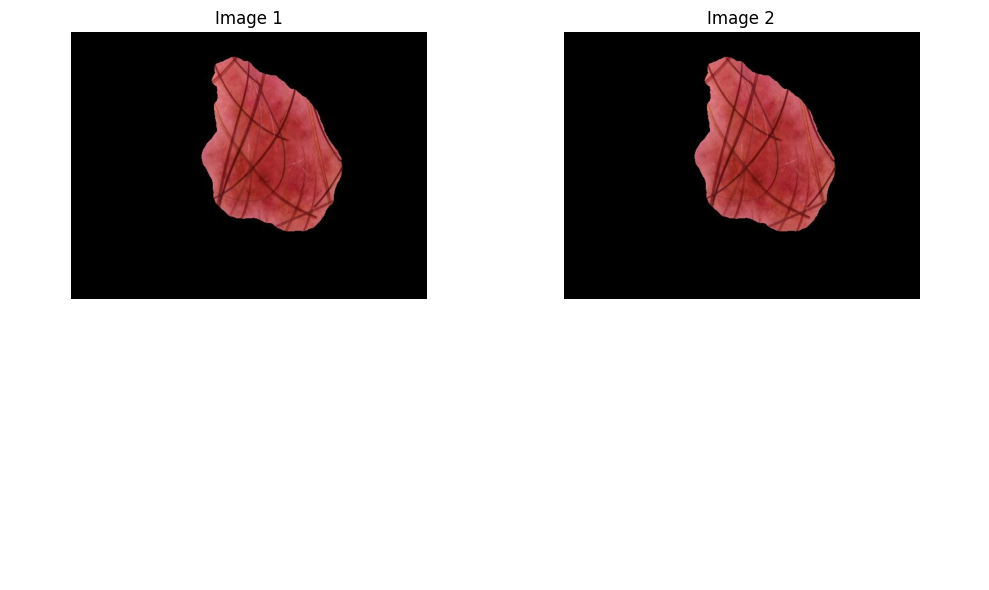

In [17]:
plot_img([image,enhanced_image])